In [99]:
from getpass import getpass

# Prompt for token securely
token = getpass('Enter your GitHub personal access token: ')

# Clone using token authentication
!git clone https://{token}@github.com/pabasara-samarakoon-4176/MDT_prediction.git

Enter your GitHub personal access token: ··········
Cloning into 'MDT_prediction'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 6), reused 16 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 135.53 KiB | 5.42 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [70]:
df = pd.read_csv('/content/drive/MyDrive/Final_year_project/datasets/Sri_Lanka_synthetic_expand_v1.csv')
df.head()

,RSRP,EARFCN_DL,Latitude_of_MDT,Longitude_of_MDT,MR_Count,Site ID,Antenna Height,Azimuth,Tilt,Latitude_of_Site,Longitude_of_Site,MDT height from MSL,Site height from MSL,Road_Coverage,Population_Density,Geohash,building_area,synthetic
0,-100.291253,2300,6.859452,80.037519,40,CM0509,40.0,20.0,3.0,6.872098,80.033649,107.998730,26,1,1454.565637,tc0zj29x,18.831225,1
1,-117.129244,1650,8.006047,80.491852,2,AN0077,50.0,10.0,2.0,8.000865,80.507141,141.877532,126,1,2383.666663,tc3jx9kq,37.227781,1
2,-99.361748,2100,7.589628,80.446392,11,KU0576,57.0,40.0,3.0,7.576478,80.444080,0.000000,180,1,5435.241276,tc35ntek,16.669445,1
3,-85.200987,2500,7.917972,81.508506,28,BA0144,50.0,200.0,3.0,7.919966,81.511204,164.052539,14,1,7429.963847,tc3vnc2t,74.357166,1
4,-97.707459,2300,8.045662,80.609251,8,AN0009,70.0,145.0,3.0,8.039274,80.596570,0.000000,144,1,7572.211449,tc3mf29v,118.346977,1


In [71]:
df.shape

(100427, 18)

In [72]:
features = ['EARFCN_DL', 'Latitude_of_MDT', 'Longitude_of_MDT',
            'MR_Count', 'Antenna Height', 'Azimuth', 'Tilt',
            'Latitude_of_Site', 'Longitude_of_Site',
            'Road_Coverage', 'Population_Density']

target = ['RSRP']

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [74]:
sequence_length = 256

In [75]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [76]:
rsrp_scaler = StandardScaler()
df['RSRP_norm'] = rsrp_scaler.fit_transform(df[['RSRP']])

In [77]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [78]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [79]:
def truncate_df(df, seq_len):
    truncate_len = (len(df) // seq_len) * seq_len
    return df.iloc[:truncate_len]

In [80]:
train_df = truncate_df(train_df, sequence_length)
val_df = truncate_df(val_df, sequence_length)
test_df = truncate_df(test_df, sequence_length)

In [81]:
def prepare_sequence_tensor(df, seq_len):
    N = len(df)
    num_seq = N // seq_len

    input_tensor = torch.tensor(df[features].values, dtype=torch.float32).view(num_seq, seq_len, -1)
    pos_tensor = torch.tensor(df[['Latitude_of_MDT', 'Longitude_of_MDT']].values, dtype=torch.float32).view(num_seq, seq_len, -1)
    target_tensor = torch.tensor(df['RSRP_norm'].values, dtype=torch.float32).view(num_seq, seq_len, 1)
    return input_tensor, pos_tensor, target_tensor

In [82]:
X_train, pos_train, y_train = prepare_sequence_tensor(train_df, sequence_length)
X_val, pos_val, y_val = prepare_sequence_tensor(val_df, sequence_length)
X_test, pos_test, y_test = prepare_sequence_tensor(test_df, sequence_length)

In [83]:
X_train.shape

torch.Size([251, 256, 11])

In [85]:
X_val.shape

torch.Size([62, 256, 11])

In [86]:
X_test.shape

torch.Size([78, 256, 11])

In [88]:
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, pos_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, pos_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, pos_test, y_test), batch_size=batch_size)

In [89]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, S, D = x.shape
        qkv = self.qkv_proj(x).reshape(B, S, self.num_heads, 3 * self.d_k).transpose(1, 2)
        Q, K, V = qkv.chunk(3, dim=-1)
        scores = Q @ K.transpose(-2, -1) / np.sqrt(self.d_k)
        attn = F.softmax(scores, dim=-1)
        context = attn @ V
        context = context.transpose(1, 2).reshape(B, S, D)
        return self.out_proj(context)

In [90]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.norm1(x + self.dropout(self.attn(x)))
        return self.norm2(x + self.dropout(self.ff(x)))

In [91]:
class RSRPTransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, num_heads=8, num_layers=6, d_ff=256):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_proj = nn.Linear(2, d_model)
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x, pos):
        x = self.input_proj(x) + self.pos_proj(pos)
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [96]:
model = RSRPTransformerModel(input_dim=len(features)).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [97]:
epochs = 150
train_losses = []
val_losses = []

print("Initial loss before training:", criterion(model(xb, pb), yb).item())
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for xb, pb, yb in train_loader:
        xb, pb, yb = xb.to(device), pb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, pb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, pb, yb in val_loader:
            xb, pb, yb = xb.to(device), pb.to(device), yb.to(device)
            preds = model(xb, pb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Initial loss before training: 1.4053013324737549
Epoch [1/150], Train Loss: 3.1997, Val Loss: 0.9943
Epoch [2/150], Train Loss: 1.1184, Val Loss: 1.0455
Epoch [3/150], Train Loss: 1.0365, Val Loss: 0.9783
Epoch [4/150], Train Loss: 1.0064, Val Loss: 0.9527
Epoch [5/150], Train Loss: 0.9879, Val Loss: 0.9333
Epoch [6/150], Train Loss: 0.9698, Val Loss: 0.9180
Epoch [7/150], Train Loss: 0.9480, Val Loss: 0.9033
Epoch [8/150], Train Loss: 0.9446, Val Loss: 0.9012
Epoch [9/150], Train Loss: 0.9394, Val Loss: 0.8972
Epoch [10/150], Train Loss: 0.9379, Val Loss: 0.8946
Epoch [11/150], Train Loss: 0.9357, Val Loss: 0.8941
Epoch [12/150], Train Loss: 0.9352, Val Loss: 0.8926
Epoch [13/150], Train Loss: 0.9348, Val Loss: 0.8934
Epoch [14/150], Train Loss: 0.9321, Val Loss: 0.8916
Epoch [15/150], Train Loss: 0.9323, Val Loss: 0.8912
Epoch [16/150], Train Loss: 0.9333, Val Loss: 0.8906
Epoch [17/150], Train Loss: 0.9317, Val Loss: 0.8910
Epoch [18/150], Train Loss: 0.9319, Val Loss: 0.8903
Epoch 

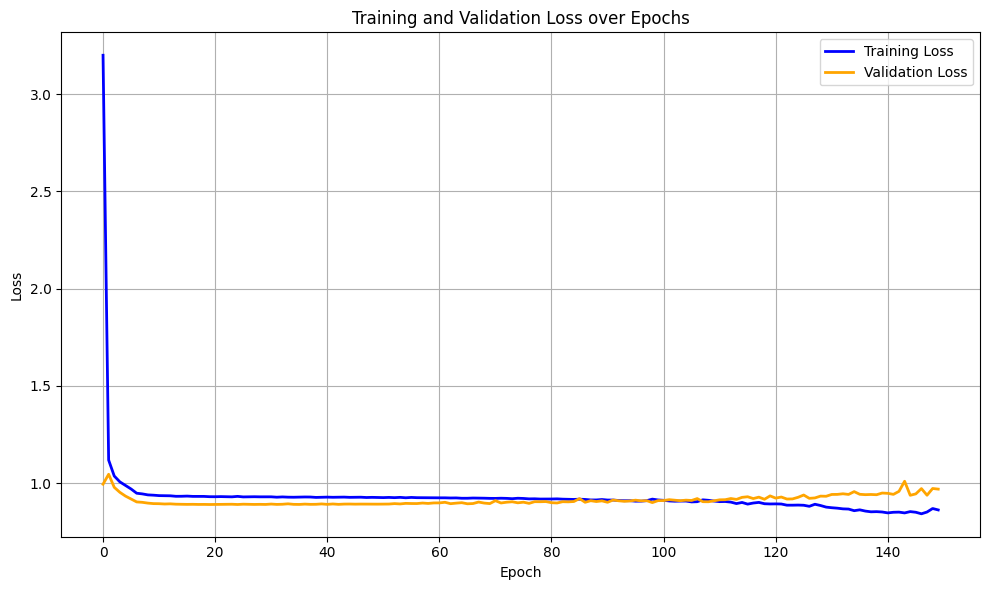

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for xb, pb, yb in test_loader:
        xb, pb, yb = xb.to(device), pb.to(device), yb.to(device)
        preds = model(xb, pb)
        predictions.append(preds.cpu().numpy())
        true_values.append(yb.cpu().numpy())

y_pred = np.concatenate(predictions).flatten()
y_true = np.concatenate(true_values).flatten()

In [31]:
y_pred_orig = rsrp_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_orig = rsrp_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_true_orig, y_pred_orig)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_orig, y_pred_orig)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R² Score: {r2:.4f}")

Test MSE: 67.3670
Test RMSE: 8.2077
Test R² Score: 0.0021
